# Set up

In [0]:
!pip install -U -q kaggle

In [0]:
!mkdir -p ~/.kaggle
!echo '' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle datasets download -d moltean/fruits

 99% 676M/684M [00:07<00:00, 99.7MB/s]
100% 684M/684M [00:07<00:00, 100MB/s] 


In [0]:
!mkdir data
!unzip -d data fruits.zip

# Data

In [0]:
import glob

In [0]:
train_files = glob.glob('data/fruits-360/Training/*/*')
test_files = glob.glob('data/fruits-360/Test/*/*')

In [0]:
train_files[:5]

['data/fruits-360/Training/Kumquats/217_100.jpg',
 'data/fruits-360/Training/Kumquats/52_100.jpg',
 'data/fruits-360/Training/Kumquats/161_100.jpg',
 'data/fruits-360/Training/Kumquats/r_153_100.jpg',
 'data/fruits-360/Training/Kumquats/r_79_100.jpg']

In [0]:
len(train_files)

53177

In [0]:
import numpy as np

In [0]:
np.random.seed(0)
np.random.shuffle(train_files)
np.random.shuffle(test_files)

In [0]:
import matplotlib.pyplot as plt
from skimage import io

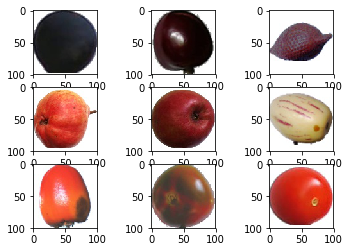

In [0]:
for i in range(9):
  plt.subplot(330 + 1 + i)
  plt.imshow(io.imread(train_files[i]))
plt.show()

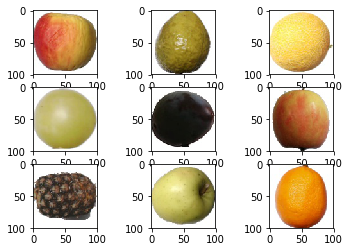

In [0]:
for i in range(9):
  plt.subplot(330 + 1 + i)
  plt.imshow(io.imread(test_files[i]))
plt.show()

In [0]:
from keras.preprocessing.image import ImageDataGenerator, img_to_array
import cv2

Using TensorFlow backend.


In [0]:
from sklearn.preprocessing import MultiLabelBinarizer

In [0]:
mlb = MultiLabelBinarizer()

In [0]:
# def train_data_gen(train_files, batch_size=32):
#   "Function to generate the data in batches."
#   start = 0
#   try:
#     while start+batch_size < len(train_files):
#       data, labels = preprocess_img(train_files[start : start + batch_size])
#       start += batch_size
#       yield data, labels
#     else:
#       offset = abs(len(train_files) - (start + batch_size))
#       data, labels = preprocess_img(train_files[start: len(train_files)] + train_files[:offset])
#       start = 0
#       yield data, labels
#   except Exception as e:
#     print(e)

In [0]:
# dg = data_gen(train_files)

In [0]:
# for tmp in dg:
#   print(len(tmp))

In [0]:
def preprocess(f):
  """Function to create the process image."""
  data = []
  labels = []
  
  for imgfile in f:
    img = cv2.imread(imgfile)
    img = cv2.resize(img, (64, 64))
    img = img_to_array(img)
    data.append(img)

    label = imgfile.split('/')[-2].split()
    labels.append(label)

  data = np.array(data) / 255.0
  labels = mlb.fit_transform(labels)
  return data, labels

In [0]:
train_data, train_labels = preprocess(train_files)
validation_data, validation_labels = preprocess(test_files)

train_data.shape, validation_data.shape, train_labels.shape, validation_labels.shape

((53177, 64, 64, 3), (17845, 64, 64, 3), (53177, 95), (17845, 95))

In [0]:
aug = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# model

In [0]:
from keras.models import Model
from keras.layers import Input, LeakyReLU, Conv2D, MaxPool2D, BatchNormalization, Concatenate, Activation, Dense, Flatten
from keras.optimizers import Adam

In [0]:
def build_model():
  """Function to build a model."""
  
  inputs = Input(shape=train_data.shape[1:], name="input_1")
  
  # block 1
  x = Conv2D(64, kernel_size=(3, 3), padding='same', strides=(2, 2), kernel_initializer='he_normal', name="conv_1")(inputs)
  x = LeakyReLU(alpha=0.3, name="activation_1")(x)
  for i in range(2, 4):
    x = Conv2D(32, kernel_size=(3, 3), padding="same", kernel_initializer='he_normal', name="conv_{}".format(i))(x)
    x = LeakyReLU(alpha=0.3, name="activation_{}".format(i))(x)
  x = MaxPool2D((2, 2), name="max_pool_1")(x)
  x = BatchNormalization(name="batch_norm_1")(x)
  
  y = Conv2D(32, kernel_size=(3, 3), padding='same', strides=(2, 2), kernel_initializer='he_normal', name="conv_4")(inputs)
  y = LeakyReLU(alpha=0.3, name="activation_4")(y)
  
  for i in range(5, 7):
    y = Conv2D(32, kernel_size=(3, 3), padding="same", kernel_initializer='he_normal', name="conv_{}".format(i))(y)
    y = LeakyReLU(alpha=0.3, name="activation_{}".format(i))(y)
  y = MaxPool2D((2, 2), name="max_pool_2")(y)
  y = BatchNormalization(name="batch_norm_2")(y)
    
  z = Concatenate(axis=1)([x, y])
  
  z = Flatten(name="flat_1")(z)
  z = Dense(128, name="dense_1")(z)
  z = Activation('relu', name="activation_7")(z)
  z = Dense(50, name="dense_2")(z)
  out = Dense(train_labels.shape[1], name="prediction_layer", activation="softmax")(z)
  
  model = Model(
      inputs=[inputs],
      outputs=[out]
  )
  
  opt = Adam(lr=1e-3, decay=(1e-3/32))
  model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])
  
  return model

In [0]:
model = build_model()

In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv_4 (Conv2D)                 (None, 32, 32, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (LeakyReLU)        (None, 32, 32, 64)   0           conv_1[0][0]                     
__________________________________________________________________________________________________
activation

In [0]:
from keras.utils import plot_model

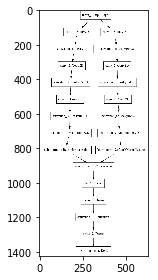

In [0]:
plot_model(model, to_file='model_1.png')
io.imshow(io.imread('model_1.png'))

# Training 

In [0]:
def plot_curves(h, epochs):
  """Function to plot the curve."""
  plt.style.use('ggplot')
  plt.figure()
  n = epochs
  
  for i in zip(['loss', 'val_loss', 'acc', 'val_acc'], ['train_loss', 'val_loss', 'train_acc', 'val_acc']):
    plt.plot(np.arange(0, n), h.history[i[0]], label=i[1])
  plt.title('Loss and Accuracy')
  plt.xlabel('Epoch #')
  plt.ylabel('Loss / Accuracy')
  plt.legend(loc="upper left")
  plt.show()

In [31]:
h = model.fit_generator(
    aug.flow(train_data, train_labels, batch_size=32),
    steps_per_epoch = train_data.shape[0] // 32,
    validation_data = aug.flow(validation_data, validation_labels, batch_size=32),
    validation_steps= validation_data.shape[0] // 32,
    epochs=100,
    verbose=2
)

# h = model.fit_generator(
#     aug.flow(train_data, train_labels, batch_size=64),
#     steps_per_epoch = 32,
#     validation_data = aug.flow(validation_data, validation_labels, batch_size=64),
#     validation_steps= 32,
#     epochs=10,
#     verbose=2
# )

Epoch 1/100
 - 71s - loss: 2.9621 - acc: 0.4595 - val_loss: 2.7843 - val_acc: 0.4850
Epoch 2/100
 - 71s - loss: 2.1777 - acc: 0.5664 - val_loss: 2.1515 - val_acc: 0.5916
Epoch 3/100
 - 71s - loss: 1.9520 - acc: 0.5942 - val_loss: 2.2563 - val_acc: 0.5429
Epoch 4/100
 - 71s - loss: 1.8306 - acc: 0.6109 - val_loss: 1.9594 - val_acc: 0.5481
Epoch 5/100
 - 70s - loss: 1.7565 - acc: 0.6184 - val_loss: 1.9734 - val_acc: 0.6492
Epoch 6/100
 - 70s - loss: 1.6890 - acc: 0.6296 - val_loss: 2.0067 - val_acc: 0.5325
Epoch 7/100
 - 70s - loss: 1.6495 - acc: 0.6348 - val_loss: 1.9381 - val_acc: 0.6170
Epoch 8/100
 - 70s - loss: 1.6100 - acc: 0.6393 - val_loss: 2.0387 - val_acc: 0.5592
Epoch 9/100
 - 70s - loss: 1.5930 - acc: 0.6422 - val_loss: 1.6579 - val_acc: 0.6326
Epoch 10/100
 - 70s - loss: 1.5567 - acc: 0.6440 - val_loss: 1.6096 - val_acc: 0.5790
Epoch 11/100
 - 70s - loss: 1.5402 - acc: 0.6486 - val_loss: 2.1533 - val_acc: 0.6026
Epoch 12/100
 - 70s - loss: 1.5306 - acc: 0.6501 - val_loss: 1.

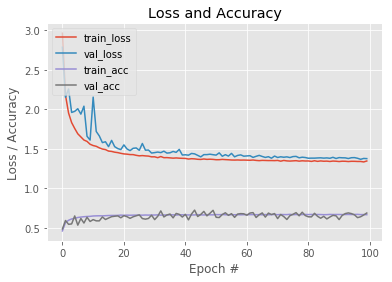

In [33]:
plot_curves(h, 100)

# evaluation

In [0]:
eval_files = glob.glob('data/fruits-360/test-multiple_fruits/*')

In [0]:
def read_img_test(imgfile):
  """Function to load image file."""
  data = []
  img = cv2.imread(imgfile)
  img = cv2.resize(img, (64, 64))
  img = img_to_array(img)
  data.append(img)
  data = np.array(data) / 255.0
  return data

In [36]:
eval_test = read_img_test(eval_files[0])
eval_test.shape

(1, 64, 64, 3)

In [38]:
y_preds = model.predict(eval_test)
tmp = np.argwhere(y_preds == np.amax(y_preds)).flatten().tolist()
c = [mlb.classes_[i] for i in tmp]
tmp , c

([0, 14], ['1', 'Carambula'])

In [0]:
def display_image(img_file):
  """Function to display the image."""
  plt.grid(False)
  io.imshow(io.imread(img_file))

In [40]:
eval_files[0]

'data/fruits-360/test-multiple_fruits/physalis2.jpg'

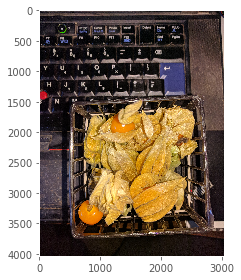

In [41]:
display_image(eval_files[0])

# saving model

In [0]:
import pickle

In [0]:
with open('model.json', 'w') as json_file:
  json_file.write(model.to_json())

In [0]:
model.save_weights('model.h5')

In [0]:
pickle.dump({'mlb': mlb.classes_}, open('mlb_classes.pkl', 'wb'))

# reload

In [0]:
import keras
import cv2
import pickle
import tensorflow as tf
import numpy as np
import warnings

warnings.filterwarnings('ignore')

In [0]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

In [0]:
loaded_model = keras.models.model_from_json(loaded_model_json)
opt = keras.optimizers.Adam(lr=1e-3, decay=(1e-3/32))
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [0]:
def data_transform(img_path):
  """function to read the image transform it."""
  img = cv2.imread(img_path)
  img = cv2.resize(img, (64, 64))
  img = keras.preprocessing.image.img_to_array(img)
  data = np.array([img]) / 255.0
  return data

In [0]:
graph = tf.get_default_graph()
mlb_classes = pickle.load(open('mlb_classes.pkl', 'rb'))

In [0]:
img_path = eval_files[0]

In [57]:
img_path

'data/fruits-360/test-multiple_fruits/physalis2.jpg'

In [66]:
with graph.as_default():
  preds = model.predict(data_transform(img_path))  # for using the image.
  tmp = np.argwhere(preds == np.amax(preds)).flatten().tolist()
  c = [mlb_classes['mlb'][i] for i in tmp]
  print(tmp , c)

[0, 14] ['1', 'Carambula']


# visualize filter weights

In [0]:
from keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt

In [0]:
from keras.preprocessing.image import load_img

In [76]:
for i in range(len(model.layers)):
  layer = model.layers[i]
  if 'conv' not in layer.name:
    continue
  print(i, layer.name, layer.output.shape)

1 conv_1 (?, 32, 32, 64)
2 conv_4 (?, 32, 32, 32)
5 conv_2 (?, 32, 32, 32)
6 conv_5 (?, 32, 32, 32)
9 conv_3 (?, 32, 32, 32)
10 conv_6 (?, 32, 32, 32)


In [0]:
ixs = [2, 5, 6]
outputs = [model.layers[i+1].output for i in ixs]

model_new = Model(inputs=model.inputs, outputs=outputs)

In [0]:
img = load_img(eval_files[10], target_size=(64, 64))
img = img_to_array(img)
img = np.expand_dims(img, axis=0)
img = img / 255.0

In [0]:
feature_maps = model_new.predict(img)

In [0]:
square = 8

In [0]:
len(feature_maps)

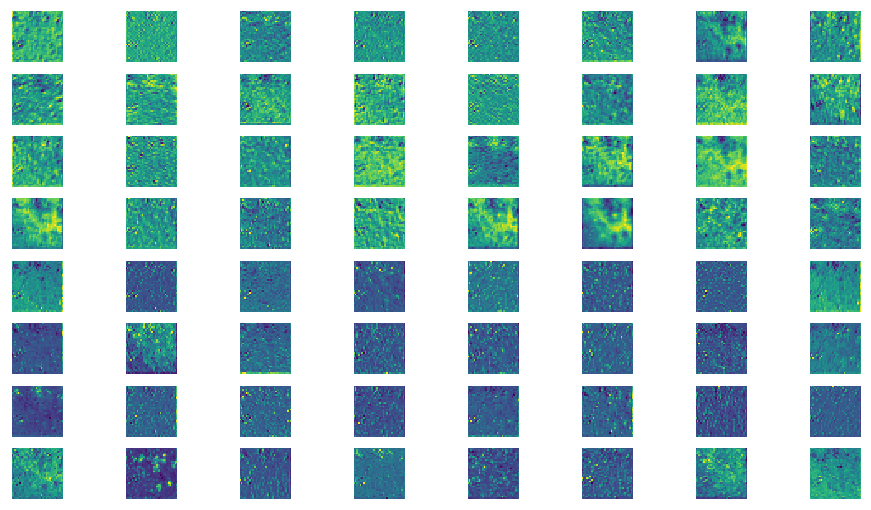

In [95]:
fig = plt.figure(figsize=(16, 9))
try:
  for fmap in feature_maps:
    ix = 1
    for _ in range(square):
      for _ in range(square):
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(fmap[0, :, :, ix-1])
        ix += 1
except:
  pass

plt.show()

# example flask serving



```
from flask import Flask, jsonify, request
from flask_cors import CORS, cross_origin

import warnings

warnings.filterwarnings("ignore")

@app1.route('/test', methods=['POST', 'GET'])
def test():
    return 'This is awesome !'


@app1.route('/classify', methods=['POST'])
@cross_origin(support_credentials=True)
def get_emotion():
    res = {'success': False}
    try:
        json_data = request.get_json()
        img_path = json_data['img_path']
        with graph.as_default():
            p = model.predict(data_transform(img_path))            
            res['prediction'] = get_predictions(p)
            res['success'] = True
        logger.info('prediction successful')
    except Exception as e:
        logger.error(e)
    finally:
        return jsonify(res)

if __name__ == "__main__":
    app1.run()

```

